## Імпортування та огляд файлу

In [247]:
import gdown

file_id = '1jYcZ6aQc-8a2985paBuiiZkFBHY3cuk9'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'my_file.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1jYcZ6aQc-8a2985paBuiiZkFBHY3cuk9
To: /content/my_file.csv
100%|██████████| 2.84M/2.84M [00:00<00:00, 32.1MB/s]


'my_file.csv'

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

In [249]:
df = pd.read_csv(output)
df.head()

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 7:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 2:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 9:44:12,2020-10-02 7:23:09,2020-10-02 7:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 7:37:33,2020-10-02 7:47:57,retail


In [250]:
df.isnull().sum()

,0
moderator,0
id_request,0
request_time,0
start_time,0
finish_time,0
team,0


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   moderator     35617 non-null  int64 
 1   id_request    35617 non-null  int64 
 2   request_time  35617 non-null  object
 3   start_time    35617 non-null  object
 4   finish_time   35617 non-null  object
 5   team          35617 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.6+ MB


In [252]:
time_col = ['request_time', 'start_time','finish_time']
for col in time_col:
  df[col] = pd.to_datetime(df[col])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   moderator     35617 non-null  int64         
 1   id_request    35617 non-null  int64         
 2   request_time  35617 non-null  datetime64[ns]
 3   start_time    35617 non-null  datetime64[ns]
 4   finish_time   35617 non-null  datetime64[ns]
 5   team          35617 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 1.6+ MB


# **Питання 1**

# Обчислюємо основні метрики

Який час виконання завдання агентом ?

In [253]:
df['handle_minutes'] = (df['finish_time'] - df['start_time']).dt.total_seconds()/60
df['handle_minutes']

,handle_minutes
0,1.516667
1,0.016667
2,4.666667
3,2.400000
4,10.400000
...,...
35612,1.783333
35613,1.933333
35614,0.033333
35615,0.033333


Який час очікування запиту в черзі ?

In [254]:
df['wait_minutes'] = (df['start_time'] - df['request_time']).dt.total_seconds()/60
df['wait_minutes']

,wait_minutes
0,10619.250000
1,9529.450000
2,10599.050000
3,9938.950000
4,2381.416667
...,...
35612,11.400000
35613,5.050000
35614,8.383333
35615,6.850000


Який час, який клієнт чекає на фінальну відповідь ?

In [255]:
df['resolve_minutes'] = (df['finish_time'] - df['request_time']).dt.total_seconds() / 60
df['resolve_minutes']

,resolve_minutes
0,10620.766667
1,9529.466667
2,10603.716667
3,9941.350000
4,2391.816667
...,...
35612,13.183333
35613,6.983333
35614,8.416667
35615,6.883333


# Оцінка відповідності очікуванням менеджменту

In [256]:
print(df['resolve_minutes'].mean().round(2))
print((df['resolve_minutes']/60).mean().round(2))

2470.97
41.18


In [257]:
print(df.groupby('team')['resolve_minutes'].mean().round(2))
resolve_team_hour = (df.groupby('team')['resolve_minutes'].mean() / 60).round(2)
print(resolve_team_hour)

team
retail        609.76
wholesale    3679.91
Name: resolve_minutes, dtype: float64
team
retail       10.16
wholesale    61.33
Name: resolve_minutes, dtype: float64


In [258]:
print(df['handle_minutes'].mean().round(2))

2.24


In [259]:
print(df.groupby('team')['handle_minutes'].mean().round(2))

team
retail       1.98
wholesale    2.42
Name: handle_minutes, dtype: float64


In [260]:
print(df.groupby('team')['wait_minutes'].mean().round(2))

team
retail        607.79
wholesale    3677.49
Name: wait_minutes, dtype: float64


Яку частку у загальному часі відповіді займає час очікування ?

In [261]:
wait_part = (df['wait_minutes'].mean() / df['resolve_minutes'].mean()) * 100
print(f"{wait_part:.2f}%")

99.91%


Який відсоток клієнтів чекає довше 45 хвилин?

In [262]:
resolve_failure = (df['resolve_minutes'] > 45).mean() * 100
print(f"{resolve_failure:.2f}%")

79.27%


In [263]:
df['resolve_hours'] = df['resolve_minutes'] / 60
# Визначаємо категорії та діапазони (0.25 год = 15 хв, 0.75 год = 45 хв)
bins = [0, 0.25, 0.75, 2, 24, float("inf")]
labels = ["< 15 хв", "15-45 хв", "45 хв - 2 год", "2 год - 1 день", "> 1 день"]
df['resolve_category'] = pd.cut(df['resolve_hours'], bins=bins, labels=labels, right=False)

resolve_analysis = df.groupby(['team', 'resolve_category']).size().unstack(fill_value=0)
resolve_percent = resolve_analysis.apply(lambda x: (x / x.sum()) * 100, axis=1).round(2)

print("--- Розподіл часу опрацювання по командах (у відсотках) ---")
resolve_percent

--- Розподіл часу опрацювання по командах (у відсотках) ---


/tmp/ipython-input-847558658.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resolve_analysis = df.groupby(['team', 'resolve_category']).size().unstack(fill_value=0)


resolve_category,< 15 хв,15-45 хв,45 хв - 2 год,2 год - 1 день,> 1 день
team,,,,,
retail,14.99,30.03,39.36,13.63,1.99
wholesale,2.09,2.85,4.88,16.96,73.22


In [264]:
df['request_time'] = pd.to_datetime(df['request_time'])
df_base = df[(df['request_time'] >= '2020-09-18') & (df['request_time'] < '2020-11-21')]
df_peak = df[(df['request_time'] >= '2020-11-21') & (df['request_time'] <= '2021-01-06')]


In [265]:
df_base.loc[:, 'resolve_hours'] = df_base['resolve_minutes'] / 60
df_base.loc[:, 'resolve_category'] = pd.cut(df_base['resolve_hours'], bins=bins, labels=labels, right=False)

df_peak.loc[:, 'resolve_hours'] = df_peak['resolve_minutes'] / 60
df_peak.loc[:, 'resolve_category'] = pd.cut(df_peak['resolve_hours'], bins=bins, labels=labels, right=False)


In [266]:
wait_base = df_base.groupby(['team', 'resolve_category'], observed=True).size().unstack(fill_value=0)
wait_peak = df_peak.groupby(['team', 'resolve_category'], observed=True).size().unstack(fill_value=0)

wait_base_percent = wait_base.apply(lambda x: (x / x.sum()) * 100, axis=1).round(2)
wait_peak_percent = wait_peak.apply(lambda x: (x / x.sum()) * 100, axis=1).round(2)

print("--- Процент очікування у Базовий період ---")
print(wait_base_percent)
resolve_failure = (df_base['resolve_minutes'] > 45).mean() * 100
print(f'Відсоток запитів у яких очікуваний час >45 : {resolve_failure:.2f}')
print("--- Процент очікування у Піковий період ---")
print(wait_peak_percent)
resolve_failure = (df_peak['resolve_minutes'] > 45).mean() * 100
print(f'Відсоток запитів у яких очікуваний час >45 : {resolve_failure:.2f}')

--- Процент очікування у Базовий період ---
resolve_category  < 15 хв  15-45 хв  45 хв - 2 год  2 год - 1 день  > 1 день
team                                                                        
retail              21.16     29.92          30.58           14.20      4.13
wholesale           12.95     16.88          27.19           37.84      5.14
Відсоток запитів у яких очікуваний час >45 : 56.82
--- Процент очікування у Піковий період ---
resolve_category  < 15 хв  15-45 хв  45 хв - 2 год  2 год - 1 день  > 1 день
team                                                                        
retail              11.08     30.10          44.92           13.26      0.63
wholesale            0.19      0.39           0.95           13.28     85.19
Відсоток запитів у яких очікуваний час >45 : 86.49


Який відсоток завдань обробляється довше 5 хвилин?

In [267]:
df_base.loc[:,'handle_failure'] = df_base['handle_minutes'] > 5
df_peak.loc[:,'handle_failure'] = df_peak['handle_minutes'] > 5
handle_base = df_base.groupby(['team', 'handle_failure'], observed=True).size().unstack(fill_value=0)
handle_peak = df_peak.groupby(['team', 'handle_failure'], observed=True).size().unstack(fill_value=0)
handle_base_percent = handle_base.apply(lambda x: (x / x.sum()) * 100, axis=1).round(2)
handle_peak_percent = handle_peak.apply(lambda x: (x / x.sum()) * 100, axis=1).round(2)
print("--- Базовий період ---")
print(handle_base_percent)
print("--- Піковий період ---")
print(handle_peak_percent)

# Загальний відсоток всіх невдалих APT
apt_failure_total = (df['handle_minutes'] > 5).mean() * 100
print(f"За весь період: {apt_failure_total:.2f}% ")


--- Базовий період ---
handle_failure  False  True 
team                        
retail          93.24   6.76
wholesale       80.30  19.70
--- Піковий період ---
handle_failure  False  True 
team                        
retail           91.8    8.2
wholesale        88.6   11.4
За весь період: 10.67% 


/tmp/ipython-input-2527156771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base.loc[:,'handle_failure'] = df_base['handle_minutes'] > 5
/tmp/ipython-input-2527156771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak.loc[:,'handle_failure'] = df_peak['handle_minutes'] > 5


Загальні показники по Піковому періоду

In [268]:
print(df_peak['resolve_minutes'].mean().round(2))
print((df_peak['resolve_minutes']/60).mean().round(2))
resolve_failure_peak = (df_peak['resolve_minutes'] > 45).mean() * 100
print(f"{resolve_failure_peak:.2f}%")
print(df_peak['handle_minutes'].mean().round(2))

2706.58
45.11
86.49%
2.22


# **Питання 2**

# Аналіз команд

Повільні агенти та дисперсія їх швидкості обробки запитів

In [269]:
df_peak_wholesale = df_peak[df_peak['team'] == 'wholesale'].copy()
df_peak_wholesale['request_day'] = df_peak_wholesale['request_time'].dt.date
moderator_peak_whosale_stat = df_peak_wholesale.groupby('moderator').agg(
    avg_handle = ('handle_minutes', 'mean'),
    median_handle = ('handle_minutes', 'median'),
    standart_dev_handle = ('handle_minutes', 'std'),
).round(2).sort_values(by='median_handle', ascending=False).head(5)
moderator_peak_whosale_stat

,avg_handle,median_handle,standart_dev_handle
moderator,,,
149,4.36,3.38,3.67
175,3.64,2.38,3.91
185,3.06,2.20,2.67
123,2.93,2.12,2.63
146,3.13,2.07,3.12


In [270]:
df_peak_retail = df_peak[df_peak['team'] == 'retail'].copy()
moderator_peak_retail_stat = df_peak_retail.groupby('moderator').agg(
    avg_handle = ('handle_minutes', 'mean'),
    median_handle = ('handle_minutes', 'median'),
    standart_dev_handle = ('handle_minutes', 'std'),
).round(2).sort_values(by='median_handle', ascending=False).head(5)
moderator_peak_retail_stat

,avg_handle,median_handle,standart_dev_handle
moderator,,,
167,4.78,3.62,3.85
141,3.76,2.79,3.28
135,2.62,2.15,1.80
178,2.36,2.08,1.86
164,2.26,1.80,1.97


Агенти які мало часу приділяють запитам в день

In [271]:
df_peak_wholesale['work_date'] = df_peak_wholesale['start_time'].dt.date
agent_load_wholesale = df_peak_wholesale.groupby('moderator').agg(
    total_work_minutes=('handle_minutes', 'sum'),
    days_worked=('work_date', 'nunique'),
    total_requests=('id_request', 'count')
).reset_index()

agent_load_wholesale['avg_daily_minutes'] = (agent_load_wholesale['total_work_minutes'] / agent_load_wholesale['days_worked']).round(1)

agent_load_wholesale['avg_daily_hours'] = (agent_load_wholesale['avg_daily_minutes'] / 60).round(1)

agent_load_wholesale = agent_load_wholesale[agent_load_wholesale['days_worked'] >= 5]
low_engagement_agents = agent_load_wholesale.sort_values(by='avg_daily_minutes', ascending=True)

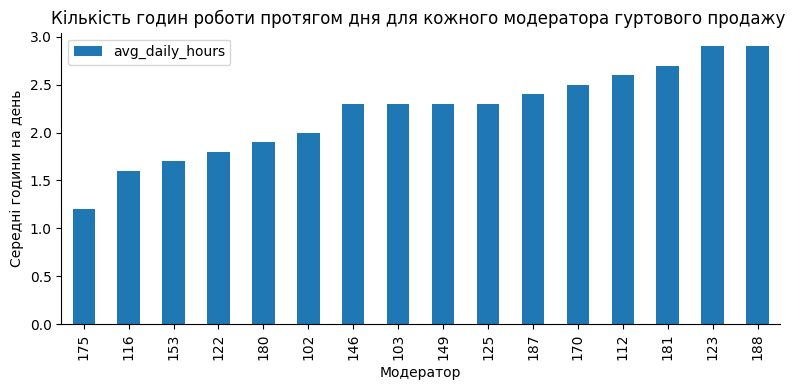

In [272]:
low_engagement_agents.plot(
    kind='bar',
    x='moderator',
    y='avg_daily_hours',
    figsize=(8, 4),
    title='Кількість годин роботи протягом дня для кожного модератора гуртового продажу '
)
plt.ylabel('Середні години на день')
plt.xlabel('Модератор')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [273]:
df_peak_retail['work_date'] = df_peak_retail['start_time'].dt.date
agent_load_retail = df_peak_retail.groupby('moderator').agg(
    total_work_minutes=('handle_minutes', 'sum'),
    days_worked=('work_date', 'nunique'),
    total_requests=('id_request', 'count')
).reset_index()

agent_load_retail['avg_daily_minutes'] = (agent_load_retail['total_work_minutes'] / agent_load_retail['days_worked']).round(1)
agent_load_retail['avg_daily_hours'] = (agent_load_retail['avg_daily_minutes'] / 60).round(1)
agent_load_retail = agent_load_retail[agent_load_retail['days_worked'] >= 5]
low_engagement_agents = agent_load_retail.sort_values(by='avg_daily_minutes', ascending=True)
high_engagement_agents = agent_load_retail.sort_values(by='avg_daily_minutes', ascending=False)

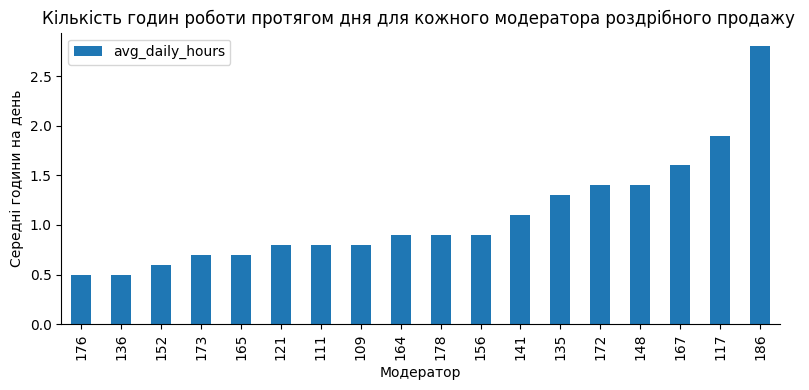

In [274]:
low_engagement_agents.plot(
    kind='bar',
    x='moderator',
    y='avg_daily_hours',
    figsize=(8, 4),
    title='Кількість годин роботи протягом дня для кожного модератора роздрібного продажу '
)
plt.ylabel('Середні години на день')
plt.xlabel('Модератор')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# **Питання 4**

In [275]:
df_peak_wholesale['request_hour'] = df_peak_wholesale['request_time'].dt.hour
df_peak_wholesale['start_hour'] = df_peak_wholesale['start_time'].dt.hour

df_peak_retail['request_hour'] = df_peak_retail['request_time'].dt.hour
df_peak_retail['start_hour'] = df_peak_retail['start_time'].dt.hour
incoming_wholesale = df_peak_wholesale.groupby('request_hour').size()
resolved_wholesale = df_peak_wholesale.groupby('start_hour').size()
incoming_retail = df_peak_retail.groupby('request_hour').size()
resolved_retail = df_peak_retail.groupby('start_hour').size()


In [276]:
queue_flow_retail = pd.DataFrame({
    'incoming': incoming_retail,
    'resolved': resolved_retail
}).fillna(0)
queue_flow_retail['difference'] = queue_flow_retail['incoming'] - queue_flow_retail['resolved']
queue = []
current = 0
for diff in queue_flow_retail['difference']:
    current = max(0, current + diff)
    queue.append(current)
queue_flow_retail['Накопичені запити'] = queue


queue_flow_wholesale = pd.DataFrame({
    'incoming': incoming_wholesale,
    'resolved': resolved_wholesale
}).fillna(0)
queue_flow_wholesale['difference'] = queue_flow_wholesale['incoming'] - queue_flow_wholesale['resolved']
queue = []
current = 0
for diff in queue_flow_wholesale['difference']:
    current = max(0, current + diff)
    queue.append(current)
queue_flow_wholesale['Накопичені запити'] = queue

print("--- Retail ---")
print(queue_flow_retail)
print("--- Wholesale ---")
print(queue_flow_wholesale)

--- Retail ---
    incoming  resolved  difference  Накопичені запити
0         49       0.0        49.0               49.0
1         21       0.0        21.0               70.0
2         16       0.0        16.0               86.0
3         40       0.0        40.0              126.0
4         63       0.0        63.0              189.0
5        158       0.0       158.0              347.0
6        269       2.0       267.0              614.0
7        492     834.0      -342.0              272.0
8        572     394.0       178.0              450.0
9        773     885.0      -112.0              338.0
10       676     394.0       282.0              620.0
11       865    1023.0      -158.0              462.0
12       628     389.0       239.0              701.0
13       671    1112.0      -441.0              260.0
14       549     399.0       150.0              410.0
15       492     587.0       -95.0              315.0
16       336     409.0       -73.0              242.0
17       376 

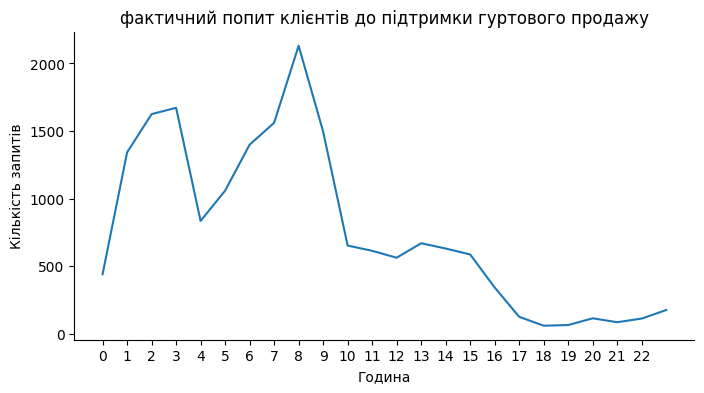

In [277]:
incoming_wholesale.plot(kind='line', figsize=(8, 4), title='фактичний попит клієнтів до підтримки гуртового продажу')
plt.xticks(range(0, 23, 1))
plt.ylabel('Кількість запитів')
plt.xlabel('Година')
plt.gca().spines[['top', 'right']].set_visible(False)

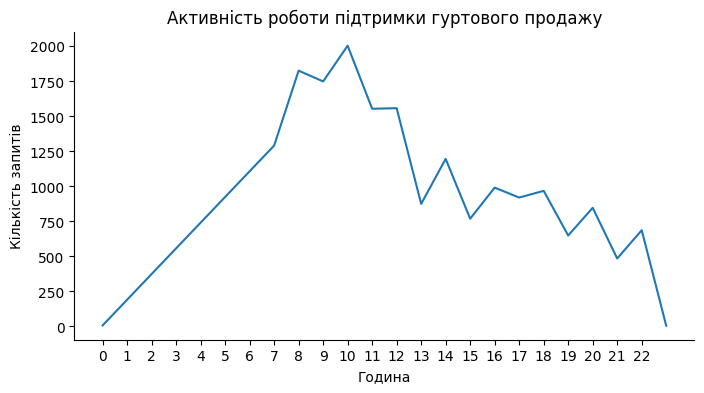

In [278]:
resolved_wholesale.plot(kind='line', figsize=(8, 4), title='Активність роботи підтримки гуртового продажу')
plt.xticks(range(0, 23, 1))
plt.ylabel('Кількість запитів')
plt.xlabel('Година')
plt.gca().spines[['top', 'right']].set_visible(False)

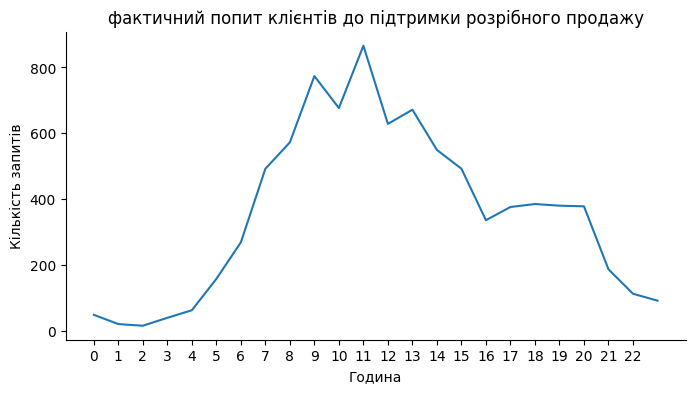

In [279]:
incoming_retail.plot(kind='line', figsize=(8, 4), title='фактичний попит клієнтів до підтримки розрібного продажу')
plt.xticks(range(0, 23, 1))
plt.ylabel('Кількість запитів')
plt.xlabel('Година')
plt.gca().spines[['top', 'right']].set_visible(False)

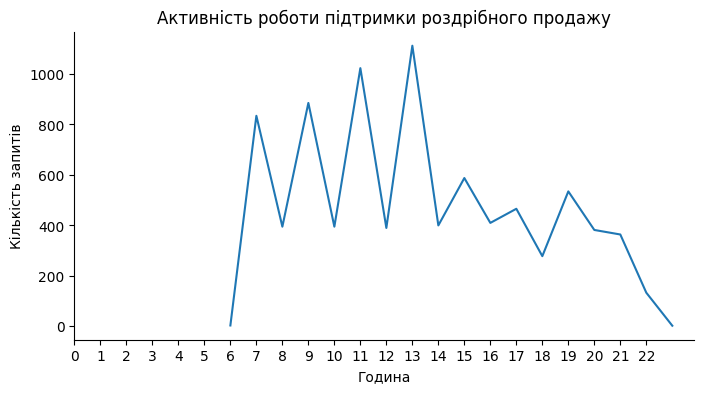

In [280]:
resolved_retail.plot(kind='line', figsize=(8, 4), title='Активність роботи підтримки роздрібного продажу')
plt.xticks(range(0, 23, 1))
plt.ylabel('Кількість запитів')
plt.xlabel('Година')
plt.gca().spines[['top', 'right']].set_visible(False)

In [281]:
num_days = df_peak_wholesale['request_time'].dt.date.nunique()
num_days

40

In [282]:
df_peak_wholesale['handle_minutes'].mean().round(2)

np.float64(2.28)

In [283]:
num_days_retail = df_peak_retail['request_time'].dt.date.nunique()
num_days_retail

41

In [284]:

df_peak_wholesale['day_name'] = df_peak_wholesale['request_time'].dt.day_name()

df_night = df_peak_wholesale[df_peak_wholesale['request_time'].dt.hour.between(0, 6)].copy()

df_night['hour'] = df_night['request_time'].dt.hour

hourly_stats_by_day_wholesale = df_night.groupby(['day_name', 'hour']).agg(
    total_requests=('id_request', 'count'),  # Всього вхідних
    active_days=('request_time', lambda x: x.dt.date.nunique())  # фактичні дні з запитами
).reset_index()

hourly_stats_by_day_wholesale['avg_requests_per_hour'] = (
    hourly_stats_by_day_wholesale['total_requests'] / hourly_stats_by_day_wholesale['active_days']
).round(1)

hourly_stats_by_day_wholesale['work_minutes'] = (
    hourly_stats_by_day_wholesale['avg_requests_per_hour'] * 2.28
).round(1)

# Необхідно FTE (Хвилин / 60)
hourly_stats_by_day_wholesale['required_FTE'] = (
    hourly_stats_by_day_wholesale['work_minutes'] / 60
).round(2)

hourly_stats_by_day_wholesale = hourly_stats_by_day_wholesale.rename(columns={
    'day_name': 'День тижня',
    'hour': 'Година',
    'total_requests': 'Всього вхідних',
    'avg_requests_per_hour': 'Сер. вхідних (за 1 год)',
    'work_minutes': 'Хвилин роботи (Сер. * 2.26)',
    'required_FTE': 'Необхідно FTE (Хвилин / 60)'
})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_stats_by_day_wholesale['day_order'] = hourly_stats_by_day_wholesale['День тижня'].map(
    {day: i for i, day in enumerate(day_order)}
)
hourly_stats_by_day_wholesale = hourly_stats_by_day_wholesale.sort_values(['day_order', 'Година']).drop('day_order', axis=1)

hourly_stats_by_day_wholesale



,День тижня,Година,Всього вхідних,active_days,Сер. вхідних (за 1 год),Хвилин роботи (Сер. * 2.26),Необхідно FTE (Хвилин / 60)
7,Monday,0,89,6,14.8,33.7,0.56
8,Monday,1,217,6,36.2,82.5,1.38
9,Monday,2,239,6,39.8,90.7,1.51
10,Monday,3,189,6,31.5,71.8,1.20
11,Monday,4,106,6,17.7,40.4,0.67
12,Monday,5,91,6,15.2,34.7,0.58
13,Monday,6,214,6,35.7,81.4,1.36
35,Tuesday,0,49,6,8.2,18.7,0.31
36,Tuesday,1,123,6,20.5,46.7,0.78
37,Tuesday,2,136,6,22.7,51.8,0.86


In [285]:
df_peak_retail['handle_minutes'].mean().round(2)

np.float64(2.08)

In [286]:
df_peak_retail['day_name'] = df_peak_retail['request_time'].dt.day_name()

df_night = df_peak_retail[df_peak_retail['request_time'].dt.hour.between(0, 6)].copy()

df_night['hour'] = df_night['request_time'].dt.hour

hourly_stats_by_day_retail = df_night.groupby(['day_name', 'hour']).agg(
    total_requests=('id_request', 'count'),  # Всього вхідних
    active_days=('request_time', lambda x: x.dt.date.nunique())  # фактичні дні з запитами
).reset_index()

hourly_stats_by_day_retail['avg_requests_per_hour'] = (
    hourly_stats_by_day_retail['total_requests'] / hourly_stats_by_day_retail['active_days']
).round(1)

hourly_stats_by_day_retail['work_minutes'] = (
    hourly_stats_by_day_retail['avg_requests_per_hour'] * 2.08
).round(1)

hourly_stats_by_day_retail['required_FTE'] = (
    hourly_stats_by_day_retail['work_minutes'] / 60
).round(2)

hourly_stats_by_day_retail = hourly_stats_by_day_retail.rename(columns={
    'day_name': 'День тижня',
    'hour': 'Година',
    'total_requests': 'Всього вхідних',
    'avg_requests_per_hour': 'Сер. вхідних (за 1 год)',
    'work_minutes': 'Хвилин роботи (Сер. * 2.26)',
    'required_FTE': 'Необхідно FTE (Хвилин / 60)'
})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_stats_by_day_retail['day_order'] = hourly_stats_by_day_retail['День тижня'].map(
    {day: i for i, day in enumerate(day_order)}
)
hourly_stats_by_day_retail = hourly_stats_by_day_retail.sort_values(['day_order', 'Година']).drop('day_order', axis=1)

hourly_stats_by_day_retail


,День тижня,Година,Всього вхідних,active_days,Сер. вхідних (за 1 год),Хвилин роботи (Сер. * 2.26),Необхідно FTE (Хвилин / 60)
6,Monday,0,10,4,2.5,5.2,0.09
7,Monday,1,5,2,2.5,5.2,0.09
8,Monday,2,7,2,3.5,7.3,0.12
9,Monday,3,7,3,2.3,4.8,0.08
10,Monday,4,8,5,1.6,3.3,0.06
11,Monday,5,33,6,5.5,11.4,0.19
12,Monday,6,34,6,5.7,11.9,0.20
34,Tuesday,0,3,2,1.5,3.1,0.05
35,Tuesday,2,1,1,1.0,2.1,0.04
36,Tuesday,4,5,3,1.7,3.5,0.06


# **Питання 5**

In [287]:
team_count = (df['team'].value_counts(normalize = True)*100).round(2)
team_count

,proportion
team,
wholesale,60.62
retail,39.38


Чи є значна різниця у середньому APT та TiQ між командами?

In [288]:
team_metrics = df_peak.groupby('team')[['handle_minutes','wait_minutes']].mean().round(2)
team_metrics

,handle_minutes,wait_minutes
team,,
retail,2.08,130.81
wholesale,2.28,3906.97


In [289]:
queue_flow_retail = pd.DataFrame({
    'incoming': incoming_retail,
    'resolved': resolved_retail
}).fillna(0)
new_index = list(range(7, 23))
queue_flow_retail = queue_flow_retail.reindex(new_index, fill_value=0)
queue_flow_retail['difference'] = queue_flow_retail['incoming'] - queue_flow_retail['resolved']
queue = []
current = 0
for diff in queue_flow_retail['difference']:
    current = max(0, current + diff)
    queue.append(current)
queue_flow_retail['Накопичені запити'] = queue


queue_flow_wholesale = pd.DataFrame({
    'incoming': incoming_wholesale,
    'resolved': resolved_wholesale
}).fillna(0)
new_index = list(range(7, 23))
queue_flow_wholesale = queue_flow_wholesale.reindex(new_index, fill_value=0)
queue_flow_wholesale['difference'] = queue_flow_wholesale['incoming'] - queue_flow_wholesale['resolved']
queue = []
current = 0
for diff in queue_flow_wholesale['difference']:
    current = max(0, current + diff)
    queue.append(current)
queue_flow_wholesale['Накопичені запити'] = queue

print("--- Retail ---")
print(queue_flow_retail)
print("--- Wholesale ---")
print(queue_flow_wholesale)

--- Retail ---
    incoming  resolved  difference  Накопичені запити
7        492     834.0      -342.0                0.0
8        572     394.0       178.0              178.0
9        773     885.0      -112.0               66.0
10       676     394.0       282.0              348.0
11       865    1023.0      -158.0              190.0
12       628     389.0       239.0              429.0
13       671    1112.0      -441.0                0.0
14       549     399.0       150.0              150.0
15       492     587.0       -95.0               55.0
16       336     409.0       -73.0                0.0
17       376     465.0       -89.0                0.0
18       385     277.0       108.0              108.0
19       380     534.0      -154.0                0.0
20       378     381.0        -3.0                0.0
21       187     363.0      -176.0                0.0
22       113     132.0       -19.0                0.0
--- Wholesale ---
    incoming  resolved  difference  Накопичені за

In [290]:
df_peak['request_hour'] = df_peak['request_time'].dt.hour
df_peak['start_hour'] = df_peak['start_time'].dt.hour

incoming_peak = df_peak.groupby('request_hour').size()
resolved_peak = df_peak.groupby('start_hour').size()

queue_flow_peak = pd.DataFrame({
    'incoming': incoming_peak,
    'resolved': resolved_peak
}).fillna(0)

new_index = list(range(7, 23))
queue_flow_peak = queue_flow_peak.reindex(new_index, fill_value=0)
queue_flow_peak['difference'] = queue_flow_peak['incoming'] - queue_flow_peak['resolved']
queue = []
current = 0
for diff in queue_flow_peak['difference']:
    current = max(0, current + diff)
    queue.append(current)
queue_flow_peak['Накопичені запити'] = queue
print("--- Обробка запитів протягом пікового періоду, якщо об'єднати дві команди---")
print(queue_flow_peak)

--- Обробка запитів протягом пікового періоду, якщо об'єднати дві команди---
    incoming  resolved  difference  Накопичені запити
7       2053    2124.0       -71.0                0.0
8       2703    2219.0       484.0              484.0
9       2269    2633.0      -364.0              120.0
10      1329    2397.0     -1068.0                0.0
11      1479    2576.0     -1097.0                0.0
12      1191    1946.0      -755.0                0.0
13      1341    1986.0      -645.0                0.0
14      1180    1594.0      -414.0                0.0
15      1079    1355.0      -276.0                0.0
16       679    1399.0      -720.0                0.0
17       502    1384.0      -882.0                0.0
18       445    1244.0      -799.0                0.0
19       445    1182.0      -737.0                0.0
20       493    1227.0      -734.0                0.0
21       273     847.0      -574.0                0.0
22       226     818.0      -592.0                0.0


/tmp/ipython-input-1166541216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak['request_hour'] = df_peak['request_time'].dt.hour
/tmp/ipython-input-1166541216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak['start_hour'] = df_peak['start_time'].dt.hour


# **Питання 3**

In [291]:
df_peak_night['day_name'] = df_peak_night['request_time'].dt.day_name()

hourly_stats_by_day_night = df_peak_night.groupby(['day_name', 'request_hour']).agg(
    total_requests=('id_request', 'count'),
    active_days=('request_time', lambda x: x.dt.date.nunique())  # фактичні дні з запитами
).reset_index()


hourly_stats_by_day_night['avg_requests_per_hour'] = (
    hourly_stats_by_day_night['total_requests'] / hourly_stats_by_day_night['active_days']
).round(1)

# Хвилин роботи (Сер. * 2.22)
# 2.22 - середня швидкість обробки запиту для двох груп
hourly_stats_by_day_night['work_minutes'] = (
    hourly_stats_by_day_night['avg_requests_per_hour'] * 2.22
).round(1)

hourly_stats_by_day_night['required_FTE'] = (
    hourly_stats_by_day_night['work_minutes'] / 60
).round(2)
hourly_stats_by_day_night = hourly_stats_by_day_night.rename(columns={
    'day_name': 'День тижня',
    'request_hour': 'Година',
    'total_requests': 'Всього вхідних',
    'active_days': 'Активних днів',
    'avg_requests_per_hour': 'Сер. вхідних (за 1 год)',
    'work_minutes': 'Хвилин роботи (Сер. * 2.26)',
    'required_FTE': 'Необхідно FTE (Хвилин / 60)'
})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_stats_by_day_night['day_order'] = hourly_stats_by_day_night['День тижня'].map(
    {day: i for i, day in enumerate(day_order)}
)

# Створюємо правильний порядок годин (22, 23 йдуть перед 0-7)
def hour_sort_key(hour):
    if hour >= 23:
        return hour - 23  # 22 -> 0, 23 -> 1
    else:
        return hour + 2   # 0 -> 2, 1 -> 3, ..., 7 -> 9

hourly_stats_by_day_night['hour_order'] = hourly_stats_by_day_night['Година'].apply(hour_sort_key)

hourly_stats_by_day_night = hourly_stats_by_day_night.sort_values(
    ['day_order', 'hour_order']
).drop(['day_order', 'hour_order'], axis=1)

In [292]:
# Середнє FTE для кожного дня тижня(ніч)
avg_fte_by_day = hourly_stats_by_day_night.groupby('День тижня').agg(
    avg_FTE=('Необхідно FTE (Хвилин / 60)', 'mean'),
    max_FTE=('Необхідно FTE (Хвилин / 60)', 'max'),
    min_FTE=('Необхідно FTE (Хвилин / 60)', 'min')
).round(2)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_fte_by_day = avg_fte_by_day.reindex(day_order)

print("=== Середнє FTE по днях тижня (нічний період 23:00-07:00) ===")
print(avg_fte_by_day)

=== Середнє FTE по днях тижня (нічний період 23:00-07:00) ===
            avg_FTE  max_FTE  min_FTE
День тижня                           
Monday         1.07     1.53     0.47
Tuesday        0.67     1.01     0.08
Wednesday      1.28     2.19     0.35
Thursday       0.96     1.68     0.35
Friday         1.52     2.27     0.30
Saturday       1.24     2.57     0.15
Sunday         1.38     2.32     0.16


In [293]:
# Фільтруємо ранковий період (08:00-10:00)
df_peak_morning = df_peak[
    df_peak['request_time'].dt.hour.between(8, 10)
].copy()

df_peak_morning['day_name'] = df_peak_morning['request_time'].dt.day_name()
df_peak_morning['request_hour'] = df_peak_morning['request_time'].dt.hour

hourly_stats_by_day_morning = df_peak_morning.groupby(['day_name', 'request_hour']).agg(
    total_requests=('id_request', 'count'),  # Всього вхідних
    active_days=('request_time', lambda x: x.dt.date.nunique())  # фактичні дні з запитами
).reset_index()

hourly_stats_by_day_morning['avg_requests_per_hour'] = (
    hourly_stats_by_day_morning['total_requests'] / hourly_stats_by_day_morning['active_days']
).round(1)

# Хвилин роботи (Сер. * 2.22)
hourly_stats_by_day_morning['work_minutes'] = (
    hourly_stats_by_day_morning['avg_requests_per_hour'] * 2.22
).round(1)

hourly_stats_by_day_morning['required_FTE'] = (
    hourly_stats_by_day_morning['work_minutes'] / 60
).round(2)

hourly_stats_by_day_morning = hourly_stats_by_day_morning.rename(columns={
    'day_name': 'День тижня',
    'request_hour': 'Година',
    'total_requests': 'Всього вхідних',
    'active_days': 'Активних днів',
    'avg_requests_per_hour': 'Сер. вхідних (за 1 год)',
    'work_minutes': 'Хвилин роботи (Сер. * 2.26)',
    'required_FTE': 'Необхідно FTE (Хвилин / 60)'
})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_stats_by_day_morning['day_order'] = hourly_stats_by_day_morning['День тижня'].map(
    {day: i for i, day in enumerate(day_order)}
)
hourly_stats_by_day_morning = hourly_stats_by_day_morning.sort_values(
    ['day_order', 'Година']
).drop('day_order', axis=1)

In [294]:
# Середнє FTE для кожного дня тижня (ранок)
avg_fte_morning = hourly_stats_by_day_morning.groupby('День тижня').agg(
    середнє_FTE=('Необхідно FTE (Хвилин / 60)', 'mean'),
    максимум_FTE=('Необхідно FTE (Хвилин / 60)', 'max'),
    мінімум_FTE=('Необхідно FTE (Хвилин / 60)', 'min'),
    всього_запитів=('Всього вхідних', 'sum')
).round(2)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_fte_morning = avg_fte_morning.reindex(day_order)

print("\n=== Середнє FTE по днях тижня (ранок 08:00-10:00) ===")
print(avg_fte_morning)


=== Середнє FTE по днях тижня (ранок 08:00-10:00) ===
            середнє_FTE  максимум_FTE  мінімум_FTE  всього_запитів
День тижня                                                        
Monday             1.82          2.29         0.91             883
Tuesday            0.90          1.15         0.65             437
Wednesday          1.64          2.00         1.18             800
Thursday           1.58          2.32         1.07             767
Friday             2.66          3.49         1.75            1080
Saturday           2.50          2.95         1.72            1215
Sunday             2.30          3.30         1.20            1119
